<img src='assets/flu_shot.png' width=900>

## Постановка задачи
В этом домашнем задании мы поучаствуем с вами в настоящем соревновании по анализу данных. Соревнование открытое -- всегда сможете вернуться к своему результату, чтобы попробовать его улучшить.

Во всех подробностях ознакомится с соревнованием можно по [**этой ссылке**](https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/).

В этом соревновании совместно с Национальным центром статистики здравоохранения США была собрана база данных, в которой респондентов опрашивали по телефону, вакинировались ли они от сезонного гриппа и от гриппа H1N1 ("свинной грипп"). 

По данным того, как отвечали респонденты, необходимо будет предсказать **две** целевые переменные:

- `h1n1_vaccine` - вакцинировался ли респондент от гриппа H1N1
- `seasonal_vaccine` - вакционировался ли респондент от сезонного гриппа.
Каждая из этих меток может принимать только одного из значений, либо 0 = "нет", либо 1 = "да" (некоторые респонденты могли  вакцинироваться два раза, некоторые только один раз, а некоторые ни одного). Задача классификации, когда необходимо прдсказывать сразу несколько меток класса называется "мультилейбловой классификацией".

Подробное описание задачи представлено на [этой странице](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/#features_list).

## План действий:

Во всех прошлых домашних заданиях я давал подробные инструкции по тому, что именно и в какой последовательности делать. Это домашнее задание будет отличаться тем, что ниже будет приведён только общий план действий. А реализацию кода я оставляю за вами.

### Список обязательных действий
1. Присоединитесь к соревнованию и скачайте тренировочную и тестовую выборки с официального сайта.

2. Загрузите данные тренировочной выборки в датафрейм, разделите матрицу предикторов и целевые переменные на `X` и `Y`. 

3.  Обучающую часть выборки (для которой известны истинные метки классов) разделите на тренировочную и тестовую часть в соотношении 80:20.

4. Проведите первичный анализ данных для тренировочной части выборки:
    - исследуйте, сбалансированы ли целевые переменные;
    - какие предикторы связаны с целевой переменной;
    
    Кстати, неплохой Exploratory data analysis приведён в данном [**блоге DrivenData**](https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/)

5. Разделите подмножество предикторов на категориальне и числовые. Проведите преобразование категориальных признаков с помощью `sklearn.preprocessing.OneHotEncoder` или других способов кодирования, если это необходимо.

6. Построение модели:
    - В качестве метрики используйте `sklearn.metrics.roc_auc_score`. (Дополнительно можете строить ROC-кривые). О том, что это такое, мы поговорим на одной из лекций (если ещё не говорили) + вы можете прочитать об этом [здесь](http://www.machinelearning.ru/wiki/index.php?title=ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F) или на любом понравившемся вам ресурсе. 
    - С точки зрения площади под ROC-кривой, сравните качество двух моделей:
        - Случайного леса, обученного на предобработанном подмножестве признаков
        - Градиентного бустинга из одной (на выбор) библиотек -- [CatBoost](https://catboost.ai/), [XGBoost](https://xgboost.readthedocs.io/en/stable/),  [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/Python-Intro.html). *Я советую начать с библиотеки Catboost --  у них хороший выбор параметров по умолчанию
        - Сделайте тюнинг параметров вашего алгоритма (с помощью `sklearn.model_selection.GridSearchCV`, `optuna` или любого другого фреймворка дискретной оптимизации). 

    - Точность модели оцените по кросс-валидации (можно разбивать на 5 частей) + на отложенной тестовой выборке.
   
7. Отправьте своё решение на DrivenData.org и добавьте в ноутбук, получающийся score (приложите скриншот с вашим никнеймом и итоговым скором).

Задание считается полностью засчитанным, если вы сделали сабмит в систему!

## Выполнение задания:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Данные тренировочной выборки

In [2]:
X = pd.read_csv('training_set_features.csv', index_col='respondent_id')
Y = pd.read_csv('training_set_labels.csv', index_col='respondent_id')

In [3]:
X.head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
X.shape

(26707, 35)

In [5]:
Y.head(5)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


Описание данных:

Набор данных с 36 столбцами. Первый столбец `respondent_id` представляет собой уникальный и случайный идентификатор. Остальные 35 функций описаны ниже.

Для всех бинарных переменных: `0` = Нет, `1` = Да.

* `h1n1_concern` - Уровень беспокойства по поводу гриппа H1N1.
`0` = Совсем не беспокоит; `1` = Не очень обеспокоен; `2` = Несколько обеспокоен; `3` = Очень обеспокоен.
* `h1n1_knowledge` - Уровень знаний о гриппе H1N1.
`0` = Нет знаний; `1` = Немного знаний; `2` = Много знаний.
* `behavioral_antiviral_meds` - Принимал противовирусные препараты. (бинарная)
* `behavioral_avoidance` - Избегал тесного контакта с другими людьми с гриппоподобными симптомами. (бинарная)
* `behavioral_face_mask` - Купил маску для лица. (бинарная)
* `behavioral_wash_hands` - Часто мыл руки или использовал дезинфицирующее средство для рук. (бинарная)
* `behavioral_large_gatherings` - Сокращено время на больших собраниях. (бинарная)
* `behavioral_outside_home` - Уменьшил контакты с людьми за пределами собственного дома. (бинарная)
* `behavioral_touch_face` - Избегал прикосновений к глазам, носу или рту. (бинарная)
* `doctor_recc_h1n1` - Вакцина против гриппа H1N1 была рекомендована врачом. (бинарная)
* `doctor_recc_seasonal` - Врач рекомендовал прививку от сезонного гриппа. (бинарная)
* `chronic_med_condition`- Имеет любое из следующих хронических заболеваний: астма или другое заболевание легких, диабет, заболевание сердца, заболевание почек, серповидно-клеточная анемия или другая анемия, неврологическое или нервно-мышечное заболевание, заболевание печени или ослабленная иммунная система, вызванная хроническим заболеванием или лекарствами, принимаемыми для лечения хронического заболевания. (бинарная)
* `child_under_6_months` - Имеет регулярный тесный контакт с ребенком в возрасте до шести месяцев. (бинарная)
* `health_worker` - Является медицинским работником. (бинарная)
* `health_insurance` - Имеет медицинскую страховку. (бинарная)
* `opinion_h1n1_vacc_effective` - Мнение респондентов об эффективности вакцины против гриппа H1N1.
`1` = Совсем не эффективно; `2` = Не очень эффективно; `3` = Не знаю; `4` = Несколько эффективен; `5` = Очень эффективно.
* `opinion_h1n1_risk` - Мнение респондента о риске заболеть гриппом H1N1 без вакцинации.
`1` = очень низкий; `2` = Несколько низкий; `3` = Не знаю; `4` = Несколько высокий; `5` = Очень высокий.
* `opinion_h1n1_sick_from_vacc` - Беспокойство респондента о том, что он может заболеть в результате вакцинации против гриппа H1N1.
`1` = Совсем не волнуюсь; `2` = Не очень волнуюсь; `3` = Не знаю; `4` = Несколько обеспокоен; `5` = Очень волнуюсь.
* `opinion_seas_vacc_effective` - Мнение респондента об эффективности вакцины против сезонного гриппа.
`1` = Совсем не эффективно; `2` = Не очень эффективно; `3` = Не знаю; `4` = Несколько эффективен; `5` = Очень эффективно.
* `opinion_seas_risk` - Мнение респондента о риске заболеть сезонным гриппом без вакцинации.
`1` = очень низкий; `2` = Несколько низкий; `3` = Не знаю; `4` = Несколько высокий; `5` = Очень высокий.
* `opinion_seas_sick_from_vacc` - Беспокойство респондента о том, что он может заболеть в результате вакцинации против сезонного гриппа.
`1` = Совсем не волнуюсь; `2` = Не очень волнуюсь; `3` = Не знаю; `4` = Несколько обеспокоен; `5` = Очень волнуюсь.
* `age_group` - Возрастная группа респондента.
* `education` - Уровень образования.
* `race` - Раса респондента.
* `sex` - Пол респондента.
* `income_poverty` - Годовой доход респондента относительно порога бедности переписи 2008 года.
* `marital_status` - Семейное положение респондента.
* `rent_or_own` - Жилищное положение респондента.
* `employment_status` - Статус занятости респондента.
* `hhs_geo_region` - Место жительства респондента с использованием географической классификации из 10 регионов, определенной Министерством здравоохранения и социальных служб США. Значения представлены в виде коротких случайных строк символов.
* `census_msa` - Проживание респондента в городских статистических районах (MSA), как это определено переписью США.
* `household_adults` - Количество других взрослых в домохозяйстве, максимальное значение – 3.
* `household_children` - Количество детей в домохозяйстве, верхний код равен 3.
* `employment_industry` - Тип отрасли, в которой работает респондент. Значения представлены в виде коротких случайных строк символов.
* `employment_occupation`- Род занятий респондента. Значения представлены в виде коротких случайных строк символов.

### 2. Exploratory data analysis 

Проверка на сбалансированность данных:

<AxesSubplot:xlabel='seasonal_vaccine', ylabel='count'>

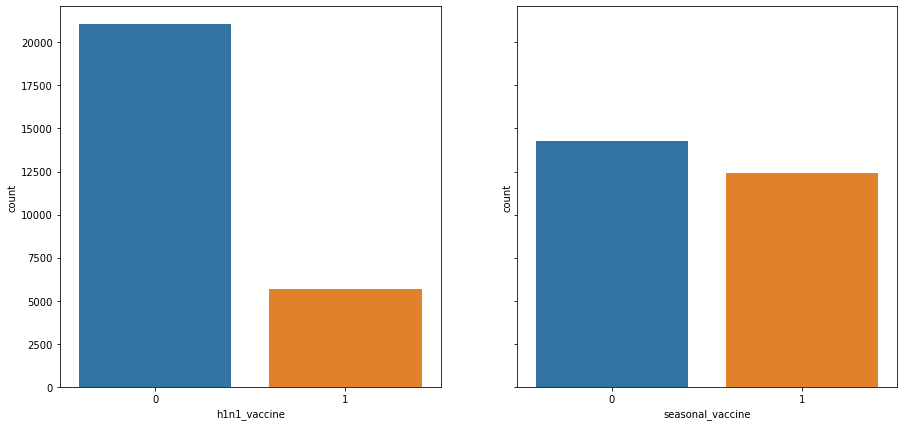

In [6]:
fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))

sns.countplot(data=Y,x='h1n1_vaccine',ax=axs[0])
sns.countplot(data=Y,x='seasonal_vaccine',ax=axs[1])

С точки зрения баланса классов, целевая вакцина против сезонного гриппа имеет сбалансированные классы, а целевая вакцина против гриппа H1N1 имеет умеренно несбалансированные классы. Также стоит отметить, что вакцину против гриппа H1N1 имели всего около 20% человек.

Проверка зависимости целевых переменных:

In [7]:
pd.crosstab(Y.h1n1_vaccine,Y.seasonal_vaccine,margins=True,normalize=True)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [8]:
#коэффициент корреляции Пирсона, рассчитанный для двух бинарных переменных
Y["h1n1_vaccine"].corr(Y["seasonal_vaccine"], method="pearson") 

0.37714265306144507

Есть скоррелированность значений меток: большинство людей без вакцины от сезонного гриппа также не имеют вакцинe от H1N1.

Посмотрим, какие предикторы связаны с целевой переменной.

In [9]:
all_data = X.join(Y)

In [10]:
all_data.head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [11]:
def vaccination_rate_plot(col,target,ax=None):

    counts = (all_data[[target, col]].groupby([target, col]).size().unstack(target))
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.set_ylabel(col)
    ax.legend().remove()

In [12]:
X.columns.values

array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outside_home', 'behavioral_touch_face',
       'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race',
       'sex', 'income_poverty', 'marital_status', 'rent_or_own',
       'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'], dtype=object)

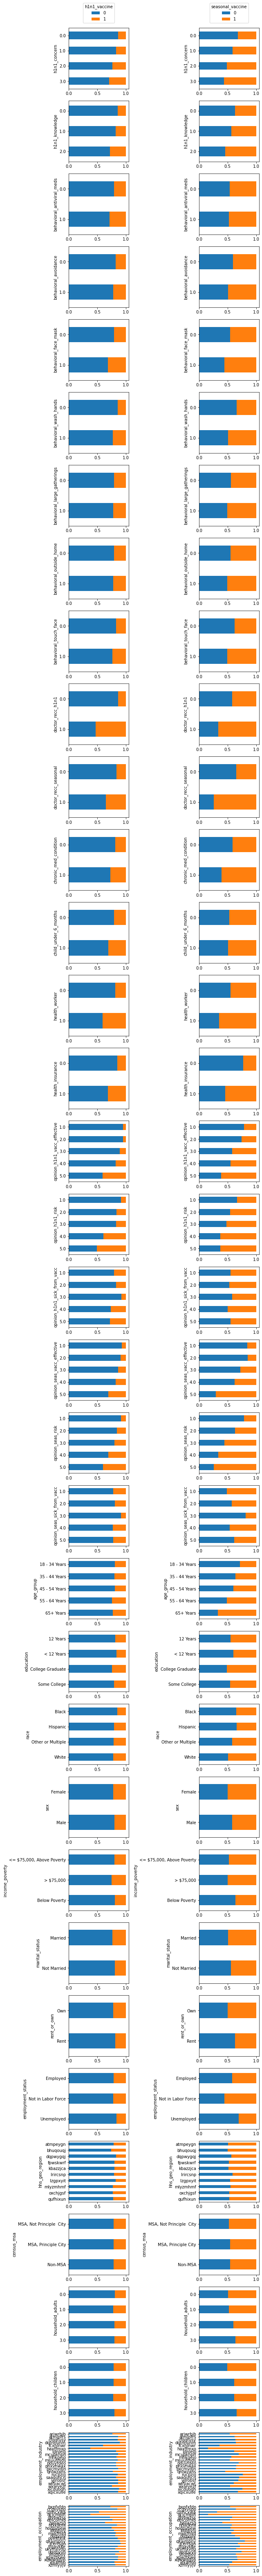

In [13]:
cols_to_plot = X.columns.values

fig, axs = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))

for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', ax=axs[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', ax=axs[idx, 1])
    
axs[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
axs[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

Судя по всему, большинство признаков связаны с целевой переменной. 

Основные наблюдения:
* От сезонного гриппа вакцинируются намного больший процент людей (примерно 1:1), чем от гриппа H1N1 (примерно 4:1).
* Чем осознаннее люди относятся к своему здоровью (беспокоятся заболеть гриппом, имеют хороший уровень знаний о гриппе, избегают контакта с инфецированными, носят маски, моют руки, не трогают лицо руками), тем больше они вакцириуются от двух типов гриппа.
* Рекоммендация врача о вакцинации сильно повышает вероятность вакцинации.
* Люди, имеющие хронические заболевания, чаще вакцинируются.
* Медицинские работники чаще вакцинируются.
* Люди, имеющие медицинскую страховку, вакцинируются чаще.
* Чем лучше мнение об эффективности вакцинации, тем чаще вакцинируются.
* Чем старше люди, тем больше они вакцинируются от сезонного гриппа. Для гриппа H1N1 такой зависимости нет.
* Для категорий "принимал противовирусные", "болезнь от вакцинации", "образование", "раса", "пол", "уровень дохода", "семейныц статус", "жилищный статус", "занятость", "место жительства" и др. не наблюдается значительных корреляций с целевыми переменными.
















### 3. Категориальные и числовые предикторы

Признаки, которые нельзя считать ранговыми:
```
hhs_geo_region
census_msa
employment_industry
employment_occupation
race
````

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [15]:
# Отделим категориальные признаки от числовых
categoricals = [col for col in X.columns.values if X[col].dtype == np.dtype('object')]
numeric = [col for col in X.columns.values if col not in categoricals]

Категориальные признаки можно преобразовать с помощью метода `One Hot Encoding`. При таком кодировании, вместо одного столбца с K категориями признака в таблицу записывается K столбцов, каждый из которых состоит из `1` (объект имеет признак с этой категорией) или `0` (объект не имеет признака с этой категорией).

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
enc = OneHotEncoder()
encoded_feat = enc.fit_transform(X[categoricals]).toarray()
encoded_feat = pd.DataFrame(encoded_feat,columns=enc.get_feature_names_out())

X_prepared = pd.concat([X[numeric],encoded_feat],axis=1)

In [93]:
X_prepared.shape

(26707, 112)

In [94]:
X_prepared.head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Разделение обучающей выборки на тренировочную и тестовую

In [20]:
import sklearn.model_selection

In [22]:
#Разделим обучающую выборку на тренировочную и валидационную в соотношении 80:20
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_prepared,Y,test_size=0.2,shuffle=True,random_state=42,stratify=Y)

### 5. Построение модели

В качестве модели будем использовать случайные леса.

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [24]:
cv_scheme = sklearn.model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

Заменим пропущенные значения:

In [25]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(X_train)

Обучим простой классификатор:

In [26]:
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_imp, Y_train)
y_pred = rf_model.predict(X_test_imp)

В качестве метрики используем `sklearn.metrics.roc_auc_score`:

In [27]:
roc_auc_score(Y_test, y_pred)

0.7113003870596468

Проведем тюнинг параметров используемого алгоритма:

In [28]:
from sklearn.model_selection import GridSearchCV
import time

rf_model = RandomForestClassifier(n_estimators=100)
param_grid = {
    'max_depth':np.arange(1,15,1),
    'min_samples_leaf':np.arange(1,40,5),
    'max_features':np.array([3,5,7]) 
}
grid_searcher = GridSearchCV(rf_model,param_grid,scoring ='roc_auc',cv=cv_scheme,verbose=2,n_jobs=-1)

Для целевой переменной `h1n1_vaccine`:

In [29]:
start = time.time()

grid_searcher.fit(X_train_imp,Y_train[Y_train.columns[0]])
stop  = time.time()
print(f"Elapsed time = {stop - start:.1f} sec") 

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time = 522.5 sec


In [31]:
grid_searcher.best_score_

0.8280852728998969

In [32]:
grid_searcher.best_params_

{'max_depth': 14, 'max_features': 7, 'min_samples_leaf': 1}

In [33]:
rf_1 = grid_searcher.best_estimator_

In [34]:
y_pred_1 = pd.DataFrame(rf_1.predict_proba(X_test_imp)[:,1])

In [35]:
y_pred_1

,0
0,0.093911
1,0.630124
2,0.041587
3,0.145040
4,0.147878
...,...
5337,0.063244
5338,0.581183
5339,0.064350
5340,0.243947


Тоже самое для целевой переменной `seasonal_vaccine`:

In [36]:
rf_model = RandomForestClassifier(n_estimators=100)
param_grid = {
    'max_depth':np.arange(1,15,1),
    'min_samples_leaf':np.arange(1,40,5),
    'max_features':np.array([3,5,7]) 
}
grid_searcher = GridSearchCV(rf_model,param_grid,scoring ='roc_auc',cv=cv_scheme,verbose=2,n_jobs=-1)

In [37]:
start = time.time()

grid_searcher.fit(X_train_imp,Y_train[Y_train.columns[1]])
stop  = time.time()
print(f"Elapsed time = {stop - start:.1f} sec") 

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time = 502.1 sec


In [38]:
grid_searcher.best_score_

0.8524954235969249

In [39]:
grid_searcher.best_params_

{'max_depth': 12, 'max_features': 7, 'min_samples_leaf': 1}

In [40]:
rf_2 = grid_searcher.best_estimator_

In [41]:
y_pred_2 = pd.DataFrame(rf_2.predict_proba(X_test_imp)[:,1])

In [42]:
y_pred_2

,0
0,0.375520
1,0.749656
2,0.179424
3,0.417354
4,0.384887
...,...
5337,0.178218
5338,0.816848
5339,0.245281
5340,0.638134


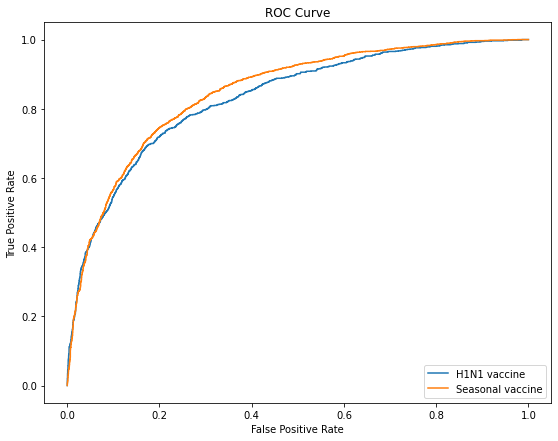

In [43]:
fig = plt.figure(figsize=(20,7))

plt.subplot(1,2,1)

plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve') 

scores1 = rf_1.predict_proba(X_test_imp)[:,1]
tpr1, fpr1, _ = roc_curve(Y_test[Y_test.columns[0]], scores1)
plt.plot(tpr1,fpr1,label='H1N1 vaccine')

scores2 = rf_2.predict_proba(X_test_imp)[:,1]
tpr2, fpr2, _ = roc_curve(Y_test[Y_test.columns[1]], scores2)
plt.plot(tpr2,fpr2,label='Seasonal vaccine')

plt.legend(loc='lower right')


In [44]:
data_predict = y_pred_1.merge(y_pred_2, left_index = True, right_index = True)
data_predict.index = Y_test.index
data_predict.columns = ["h1n1_vaccine","seasonal_vaccine"]
data_predict.head(5)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.093911,0.375520
1215,0.630124,0.749656
10540,0.041587,0.179424
7407,0.145040,0.417354
14697,0.147878,0.384887


### 7. Предсказание данных для тестовой выборки

Предскажем вероятность вакцинации на финальном тестовом наборе данных:

In [76]:
X_test_data = pd.read_csv('test_set_features.csv', index_col='respondent_id')

In [112]:
X_test_data

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


In [77]:
X_test_data.shape

(26708, 35)

In [81]:
categoricals = [col for col in X_test_data.columns.values if X_test_data[col].dtype == np.dtype('object')]
numeric = [col for col in X_test_data.columns.values if col not in categoricals]

In [82]:
from sklearn.preprocessing import OneHotEncoder

In [114]:
enc = OneHotEncoder()
encoded_feat = enc.fit_transform(X_test_data[categoricals]).toarray()
encoded_feat = pd.DataFrame(encoded_feat,columns=enc.get_feature_names_out())
encoded_feat.index = X_test_data.index

In [117]:
X_prepared = pd.concat([X_test_data[numeric],encoded_feat],axis=1)

In [118]:
X_prepared_final

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [119]:
X_prepared_final.shape

(26708, 112)

In [120]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp = imp.fit(X_prepared_final)
X_test_final = imp.transform(X_prepared_final)

In [121]:
y_pred_1_final = pd.DataFrame(rf_1.predict_proba(X_test_final)[:,1])
y_pred_2_final = pd.DataFrame(rf_2.predict_proba(X_test_final)[:,1])

In [123]:
data_predict = y_pred_1_final.merge(y_pred_2_final, left_index = True, right_index = True)
data_predict.index = X_test_data.index
data_predict.columns = ["h1n1_vaccine","seasonal_vaccine"]
data_predict.head(5)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.174337,0.424725
26708,0.028108,0.097791
26709,0.460971,0.722419
26710,0.415425,0.749803
26711,0.289918,0.456965


In [124]:
data_predict.shape

(26708, 2)

In [125]:
data_predict.to_csv('data_predict.csv')

После отправки решения на DrivenData.org получился score:

<img src='submission.png' width=900>